# Introduction

Since December 2019, a new coronavirus called 2019-nCoV (Covid-19) has started to spread worldwide. Despite the best efforts to take various measures including lockdown, vaccines, wearing masks, and social distance, more than 300 million people have been infected with the Covid-19 and more than 5.7 million people have died as a result as of today. The world's population is hoping that the pandemic will end soon, but new variants of the virus are emerging and making Covid-19 even worse. At this moment, what is the factors effect on the spread of Covid-19 and how they influence the daily case number has become a topic of concern for all.

This report use data from the Johns Hopkins University Center for Systems Science and Engineering to conduct the analysis about how the vaccination and policies against Covid-19 affect the daily case number. It will mainly evaluate that wether the lockdown policy and vaccination have significant effect on reducing case number, and how the date correlated to the spread of Covid-19. At the end of report, I will also use the data to predict the trend of Covid-19 case numbers for different countries.

# Project 1 (part 1)

The dataset includes 280 countries or regions' data from 2020-01-22 to present, in each country and each date, there is the number indicate the cumulative confirmed cases number of Covid-19. Although the dataset is keeping update, in this analysis we will only use the data from begin to 2022-02-23. The datas updated after this date could be used to vertify the prediction. 

Below is the code using for data cleaning.

In [1]:
import pandas as pd
import numpy as np
import qeds
import datetime
import geopandas as gpd
import matplotlib.colors as mplc
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm #for linear regression: sm.ols

from shapely.geometry import Point
from geopandas import GeoDataFrame

%matplotlib inline
# activate plot theme
import qeds
qeds.themes.mpl_style();

In [2]:
#Import data from csv file.
df = pd.read_csv(r'G:\UTSG\2022 Winter\ECO225\Project\dataset\csse_covid_19_data\csse_covid_19_time_series\time_series_covid19_confirmed_global.csv')

In [3]:
#Drop column that we don't need.
df.drop(['Lat', 'Long'], axis=1, inplace=True)

In [4]:
#Some of the columns' name have error, filt them and rename them.
for label in df.columns:
    if '2' in label:
        if '200' in label:
            new_label = label[3:]
            df.rename(columns={label: new_label}, inplace=True)
        if '201' in label:
            new_label = label[2:]
            df.rename(columns={label: new_label}, inplace=True)

In [5]:
#Group table by country/region and sum the data in same date for each country/region. Also edit the countries name to match with 
#other dataframe.
all_countries = df.groupby('Country/Region').sum()
all_countries.columns = pd.to_datetime(all_countries.columns)
all_countries.rename({'US':'United States of America', 'Korea, South':'South Korea', 'Bosnia and Herzegovina':'Bosnia and Herz.',
                      'Central African Republic':'Central African Rep.','Congo (Kinshasa)':'Dem. Rep. Congo',
                      'Congo (Brazzaville)':'Congo', "Cote d'Ivoire":"Côte d'Ivoire", 'Dominican Republic':'Dominican Rep.', 
                      'Equatorial Guinea':'Eq. Guinea', 'Eswatini':'eSwatini', 'Solomon Islands':'Solomon Is.', 
                      'South Sudan':'S. Sudan', 'Taiwan*':'Taiwan'}, inplace=True)
all_countries.info()

<class 'pandas.core.frame.DataFrame'>
Index: 196 entries, Afghanistan to Zimbabwe
Columns: 744 entries, 2020-01-22 to 2022-02-03
dtypes: int64(744)
memory usage: 1.1+ MB


After cleaning the data, we keep 196 countries or region and 744 days observational data. Because there are too many countries or regions in the dataset, I will choose some of them with classic feature to represent the other countries. Hence, I sour the data by the most recent confirmed cases number and the plot the graph to see the overall tendency.

In [6]:
#Sort the data based on recent confirmed case number, from high to low.
top_10 = all_countries.sort_values('2/3/22', ascending=False).head(10)
top_10.columns.name = 'date'
top_10 = top_10.T

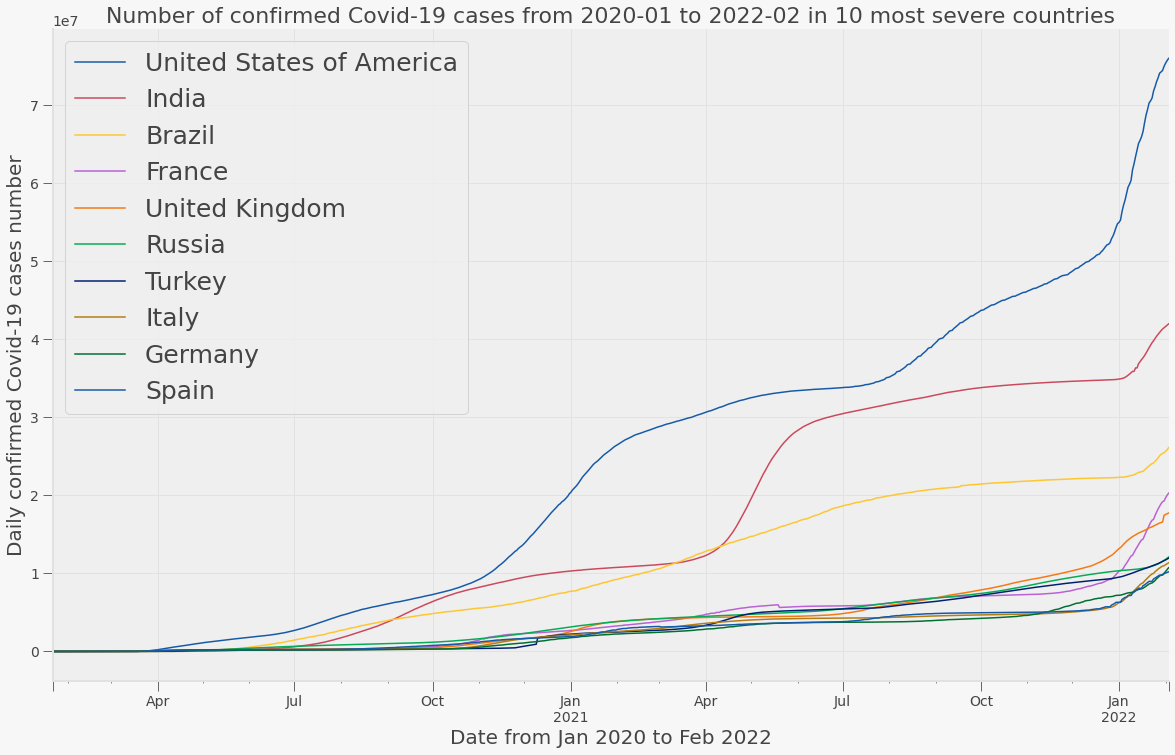

In [7]:
fig, ax = plt.subplots(figsize=(20,12))
top_10.plot.line(ax=ax)
ax.set_xlabel('Date from Jan 2020 to Feb 2022', fontsize=20)
ax.set_ylabel('Daily confirmed Covid-19 cases number', fontsize=20)
ax.set_title('Number of confirmed Covid-19 cases from 2020-01 to 2022-02 in 10 most severe countries', fontsize=22)
ax.legend(fontsize=25)

In this plot, the independent variable x is time and country/region, and the dependent variable y is the confirmed case number.

We found that the US, India, Brazil, France, UK, Russia, Turkey, Italy, Germany, and Spain belong to the top 10. Most of them have a similar trending pattern except the US, India, and Brazil have an extremely increased confirmed cased. Generally, the number of confirmed cases in all these countries increased over time and started to show a significant increase in December 2021. This trend is consistent with what we know about the Covid-19 variant of the virus Omicron, which is spreading faster and with greater intensity. This means that in these countries/regions, different locations, demographic information, and geographic information do not affect the Covid-19 spreading pattern, so we could use some of the countries to represent the overall tendency.

Besides, we also want to check if the countries have the most confirmed cases number at the beginning of the pandemic, which means the countries that were first affected when the covid-19 outbreak began, have a different pattern. So we will plot another graph to see.

Notice that because the pandemic is not fully spread in the first few months, it is hard to say which countries have the fastest spread speed. So I will check the cumulative cased number in the first quarter in 2020 instead. Also, for the convenience of the following analysis, I will create a new dataframe that contains non-cumulative daily cases number in each country.

In [8]:
#Create a new dataframe contains the daily confirmed cases number.
all_daily = all_countries.T.diff()
all_daily = all_daily.T
all_daily[pd.to_datetime('2020-01-22')] = all_countries[pd.to_datetime('2020-01-22')]

#Replace some error value.
for time in all_daily.columns:
    for country in all_daily.index:
        if all_daily[time][country] < 0:
            all_daily.at[country, time] = 0

#Group daily confirmed numbers by quarter.
all_daily_T = all_daily.T
all_gbqt = all_daily_T.groupby(pd.Grouper(freq='Q')).sum()
all_gbqt = all_gbqt.T

In [9]:
#Sort the data based on confirmed case number in 2020 first quater, from high to low.
top_10_2020_qt = all_gbqt.sort_values(pd.to_datetime('3/31/20'), axis=0, ascending=False).head(10)
top_10_2020_qt = top_10_2020_qt.T

#Get the full dafa from top 10 cases countries.
top10_2020_days = pd.DataFrame()
for name in top_10_2020_qt.T.index:
    top10_2020_days[name] = (all_countries.T[name])

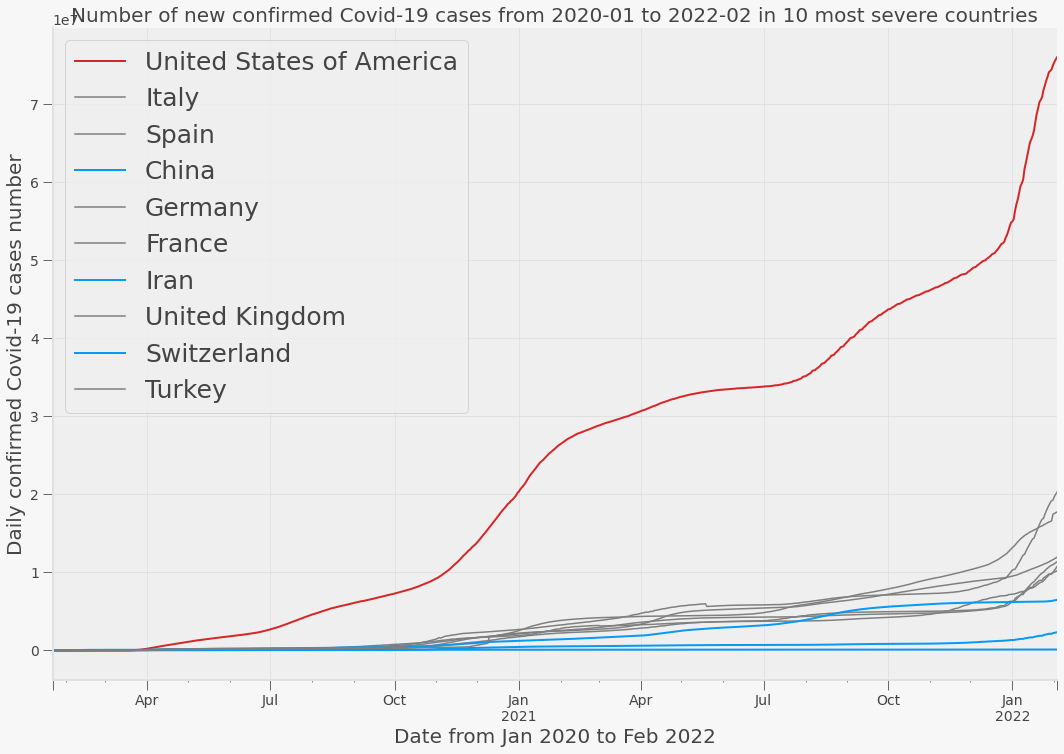

In [10]:
fig, ax = plt.subplots(figsize=(18,12))

emph_color = '#d62728'
sec_color = '#069af3'
other_color = '#7f7f7f'

for country in top10_2020_days.columns:
    if country == 'United States of America':
        top10_2020_days[country].plot(ax=ax, legend=True, color=emph_color, linewidth=2.0)
    elif country in ['China', 'Iran', 'Switzerland']:
        top10_2020_days[country].plot(ax=ax, legend=True, color=sec_color, linewidth=2.0)
    else:
        top10_2020_days[country].plot(ax=ax, legend=True, color=other_color, linewidth=1.5)

ax.set_xlabel('Date from Jan 2020 to Feb 2022', fontsize=20)
ax.set_ylabel('Daily confirmed Covid-19 cases number', fontsize=20)
ax.set_title('Number of new confirmed Covid-19 cases from 2020-01 to 2022-02 in 10 most severe countries', fontsize=20)
ax.legend(fontsize=25)

In this plot, we found that China, Iran, and Switzerland had a very high number of confirmed cases at the beginning of the pandemic. However, as time has passed, the number of confirmed cases in these countries has decreased significantly and shows a different pattern with other countries. Other countries have been in the top 10 for confirmed cases since the beginning of the pandemic till the present. On the other hand, India, Brazil, and Russia, which started relatively uninfected, now have become the countries with the highest number of confirmed cases. We are curious about the different pattern, and want to explore if the vaccination rate affects that.

# Project 2

## The Message

Although there is an upward trend in the number of confirmed cases in the first two months of the emerge of new novel Coronavirus variant, there is a downward trend in the number of confirmed cases for certain cycles as the vaccine rate increases. This means that the increase in vaccination rates is likely to be effective in reducing the number of cases, but further analysis is still needed.

I choose to use the the vaccination rate and confirmed cases number in United States as my message plot, but due to the coding order, please see the plot at the end of part 2.

## Detailed plot (part 2)

In [11]:
#Define the countries we want to research.
rsch_countries = ['China', 'Switzerland', 
                  'United States of America', 'United Kingdom', 
                  'India', 'Russia']

#Create a dataframe contains only the data from research countries.
per_day = pd.DataFrame()
for country in rsch_countries:
    per_day[country] = all_daily.T[country]

per_day = per_day.T
for date in per_day.columns:
    if date < pd.to_datetime('2020-12-15'):
        per_day.drop(date, axis=1, inplace = True)

per_day = per_day.T
per_day = per_day.groupby(pd.Grouper(freq='W')).sum()

per_day.reset_index(inplace=True)

In [12]:
#Import vaccination data from csv file.
vacc = pd.read_csv(r'G:\UTSG\2022 Winter\ECO225\Project\dataset\vaccination\country_vaccinations.csv')
vacc['date'] = pd.to_datetime(vacc['date'])
vacc.loc[vacc['country'] == 'United States', 'country'] = 'United States of America'
see = vacc.loc[vacc['country'] == 'france', 'total_vaccinations_per_hundred']

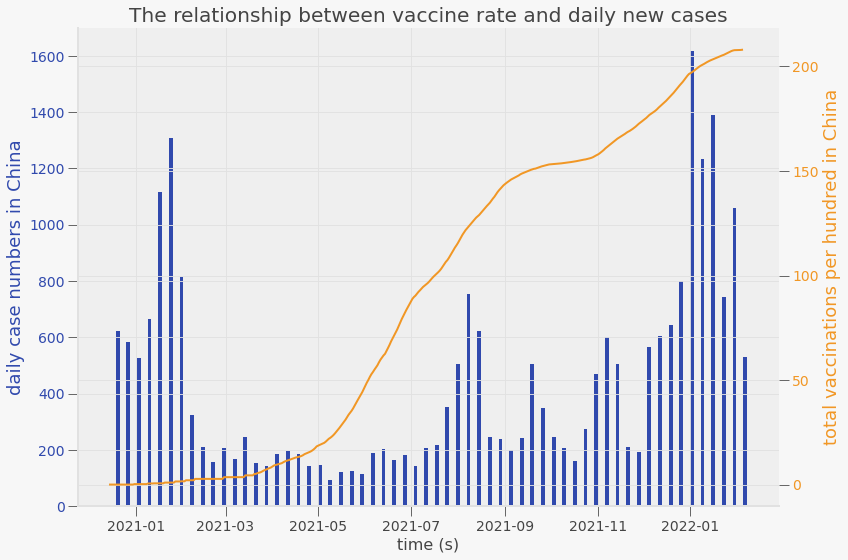

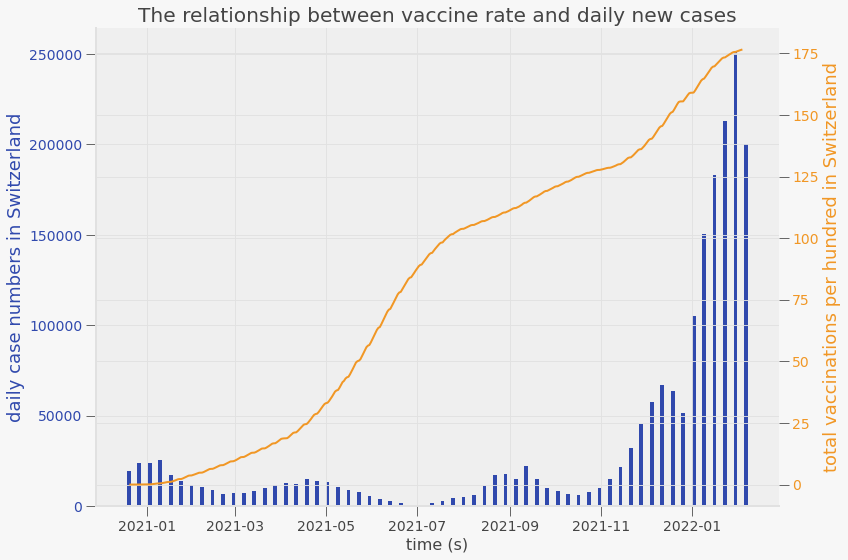

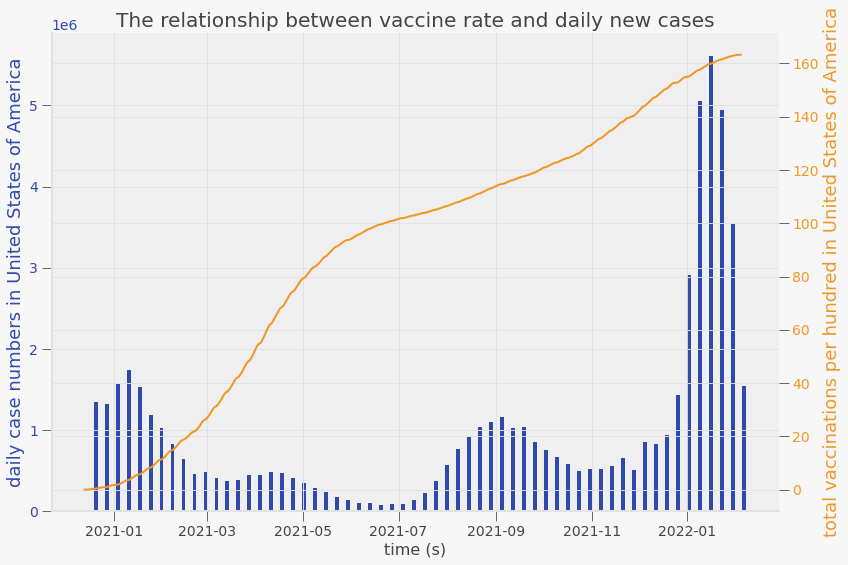

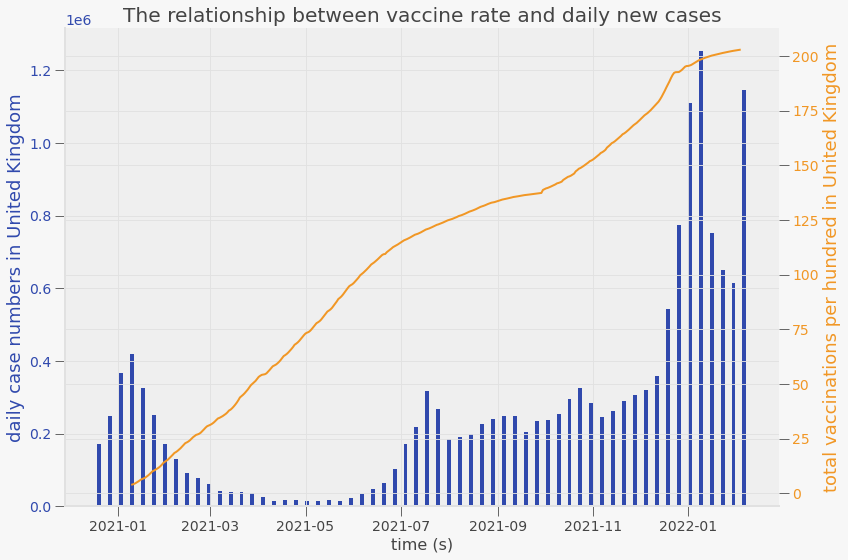

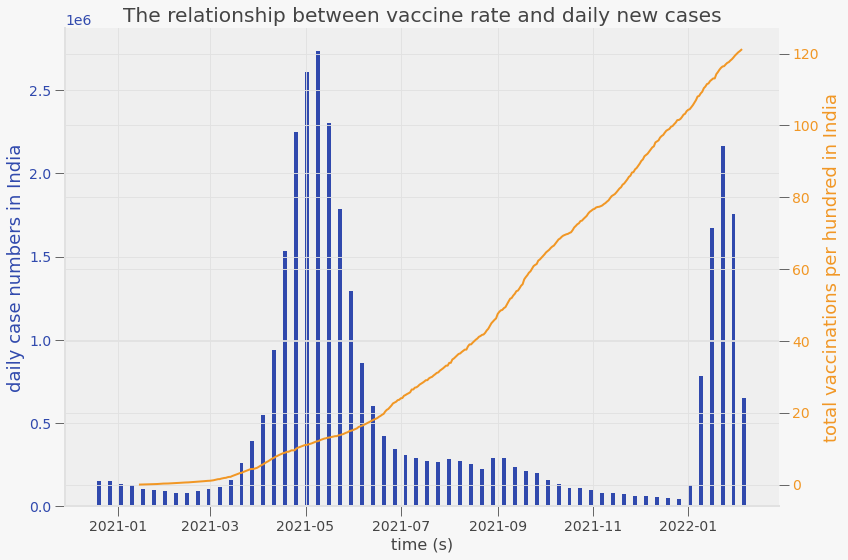

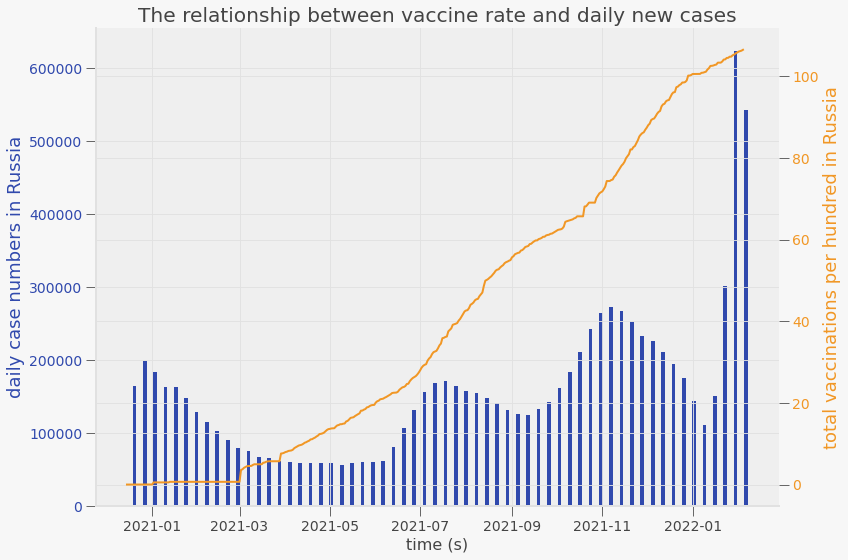

In [13]:
for country in rsch_countries:
    fig, ax1 = plt.subplots(figsize=(12, 8))

    color = '#3049ad'
    ax1.set_xlabel('time (s)', fontsize=16)
    ax1.set_ylabel('daily case numbers in ' + country, color=color, fontsize=18)
    ax1.bar(per_day['date'], per_day[country], color=color, width=2.5)
    ax1.tick_params(axis='y', labelcolor=color)
    
    ax1.set_title('The relationship between vaccine rate and daily new cases')

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = '#f19725'

    x = vacc.loc[vacc['country'] == country, 'date']
    y = vacc.loc[vacc['country'] == country, 'total_vaccinations_per_hundred']
    y.fillna(method="ffill", inplace=True)

    ax2.set_ylabel('total vaccinations per hundred in ' + country, color=color, fontsize=18)  # we already handled the x-label with ax1
    ax2.plot(x, y, color=color, linewidth=2)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped

    plt.show()

Because both vaccination rate and the daily confirmed cases number are time seris data, I plot them in one figure for each research countries. In these graphs, the X variable is time, and the Y variable is the number of confirmed cases per day and the number of vaccinations per 100 people. We can observe the trend and correlation between the two Y variables in the graph.

Based on vaccine rates and daily new confirmed cases in several representative countries, we found that the number of confirmed cases declined over some period of time as vaccine rates increased. Specifically, the number of confirmed cases declined significantly after January-March 2020, May-July 2020, September-November 2020, and Feburary 2022, taking the US as an example. December 2020 to January 2021, April-May 2021, and November 2021 to January 2022, according to the World Health Organization, produced the Gamma, Delta, and Omicron variants, respectively. New variants may affect the vaccine's effectiveness, so this short-term increase is understandable.

At the same time, we have noticed that after the emergence of the Omicron variant, the number of confirmed cases in each country has increased significantly. This may mean that the vaccine is least effective against omicron. Meanwhile, China has seen a significant drop in the number of confirmed cases since January 2022, reducing the infection rate at Omicron faster than other countries. This particular pattern that may be linked to other factors, such as quarantine and lockdown policies.

## Main Message plot

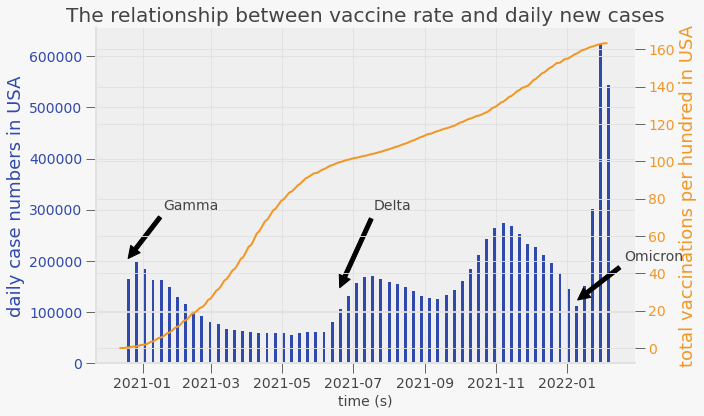

In [14]:
fig, ax1 = plt.subplots(figsize=(10, 6))
color = '#3049ad'
ax1.set_xlabel('time (s)', fontsize=14)
ax1.set_ylabel('daily case numbers in USA', color=color, fontsize=18)
ax1.bar(per_day['date'], per_day[country], color=color, width=2.5)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_title('The relationship between vaccine rate and daily new cases')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = '#f19725'
x = vacc.loc[vacc['country'] == 'United States of America', 'date']
y = vacc.loc[vacc['country'] == 'United States of America', 'total_vaccinations_per_hundred']
y.fillna(method="ffill", inplace=True)
ax2.set_ylabel('total vaccinations per hundred in USA', color=color, fontsize=18)  # we already handled the x-label with ax1
ax2.plot(x, y, color=color, linewidth=2)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped

ax1.annotate('Omicron', xy=(pd.to_datetime('2022-01-08'), 120000), xytext=(pd.to_datetime('2022-2-19'), 200000),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax1.annotate('Gamma', xy=(pd.to_datetime('2020-12-18'), 200000), xytext=(pd.to_datetime('2021-1-19'), 300000),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax1.annotate('Delta', xy=(pd.to_datetime('2021-06-18'), 140000), xytext=(pd.to_datetime('2021-7-19'), 300000),
            arrowprops=dict(facecolor='black', shrink=0.05))

plt.show()

## Part 3

In [15]:
# Grab low resolution world file
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world = world.set_index("name")

all_gbqt_map = all_gbqt.copy()
all_gbqt_map['geometry'] = world['geometry']
all_gbqt_map = GeoDataFrame(all_gbqt_map)

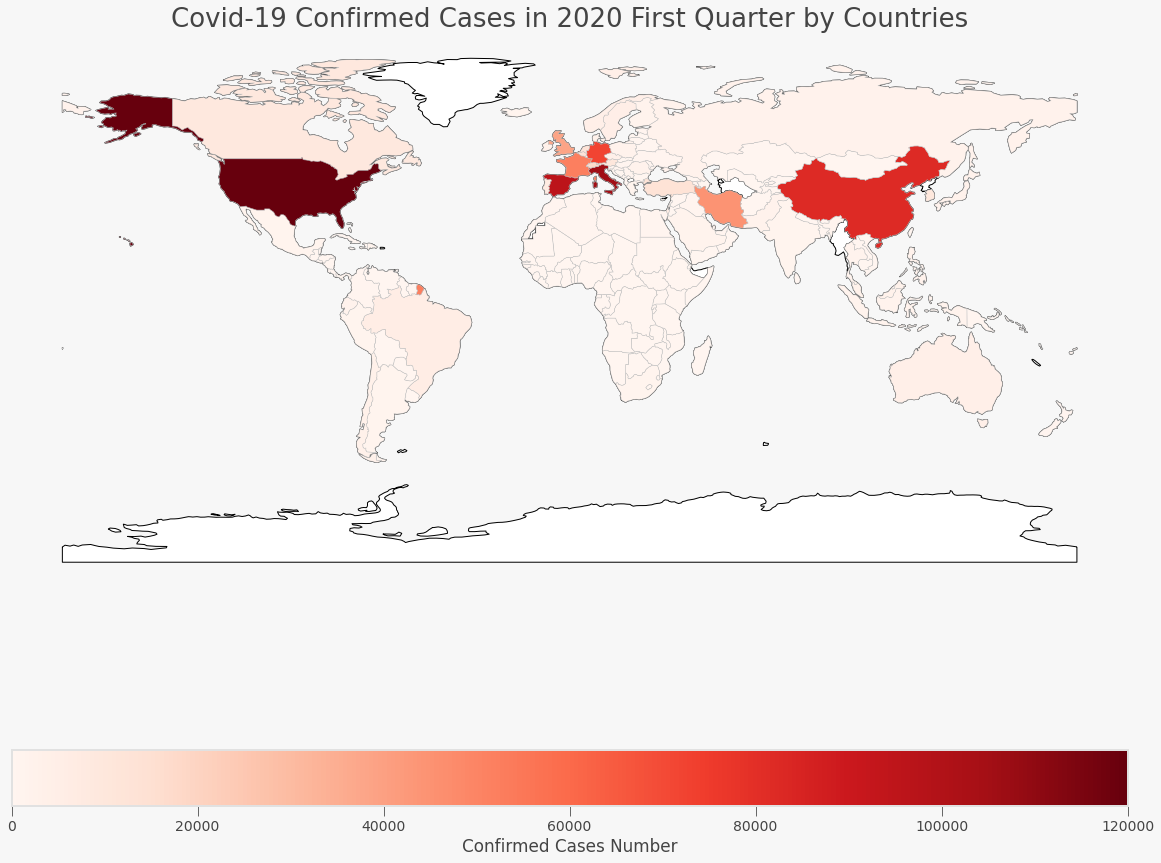

In [16]:
fig, gax = plt.subplots(figsize=(20, 20))
world.plot(ax=gax, edgecolor='black',color='white')

# Plot the covid-19 data to color

all_gbqt_map.plot(column=pd.to_datetime('2020-03-31'), cmap='Reds', ax=gax, linewidth=0.5, edgecolor='0.8', 
                  legend=True, legend_kwds={'label': "Confirmed Cases Number",'orientation': "horizontal"}, 
                  norm=plt.Normalize(vmin=0, vmax=120000))

# Add text to let people know what we are plotting
gax.set_title('Covid-19 Confirmed Cases in 2020 First Quarter by Countries', fontsize = 26)

# I don't want the axis with long and lat
plt.axis('off')

# By the way, if you haven't read the book 'longitude' by Dava Sobel, you should...
gax.set_xlabel('longitude')
gax.set_ylabel('latitude')

plt.show()

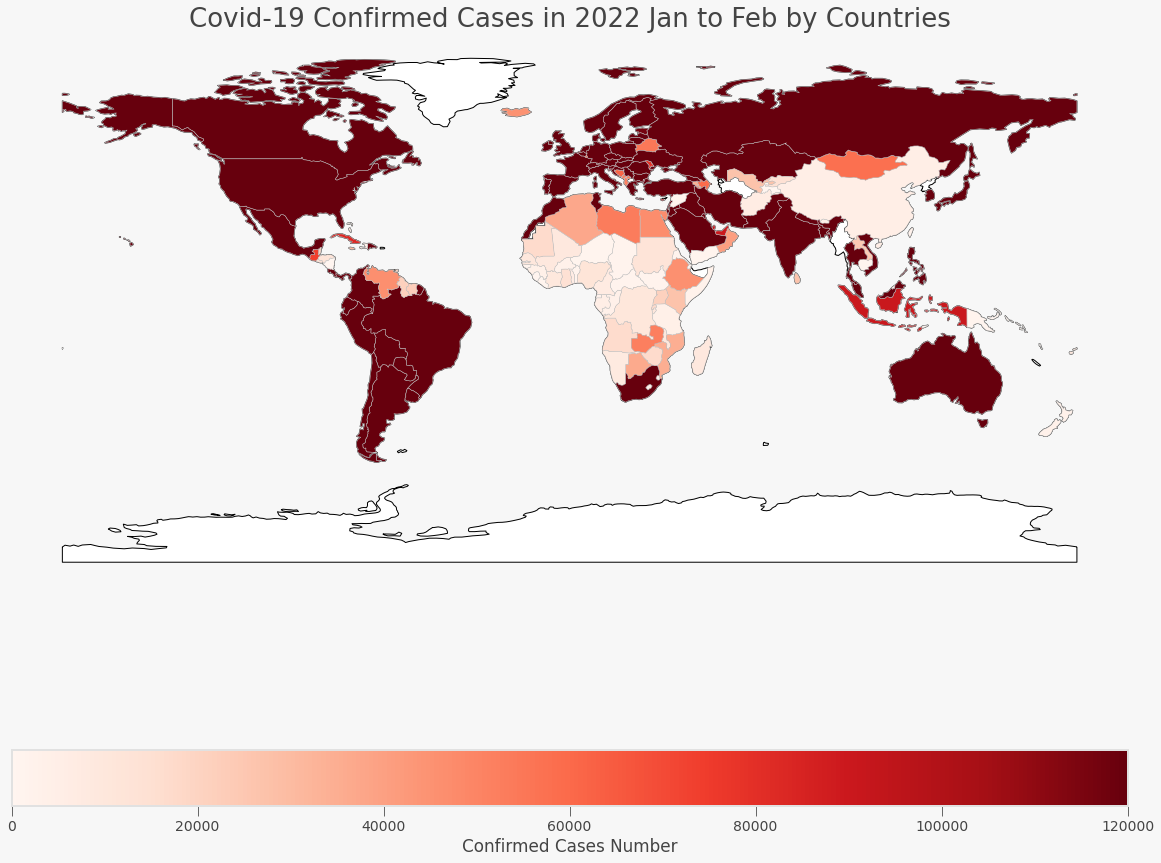

In [17]:
fig, gax = plt.subplots(figsize=(20, 20))
world.plot(ax=gax, edgecolor='black',color='white')

# Plot the covid-19 data to color

all_gbqt_map.plot(column=pd.to_datetime('2022-03-31'), cmap='Reds', ax=gax, linewidth=0.5, edgecolor='0.8', 
                  legend=True, legend_kwds={'label': "Confirmed Cases Number",'orientation': "horizontal"}, 
                  norm=plt.Normalize(vmin=0, vmax=120000))

# Add text to let people know what we are plotting
gax.set_title('Covid-19 Confirmed Cases in 2022 Jan to Feb by Countries', fontsize = 26)

# I don't want the axis with long and lat
plt.axis('off')

# By the way, if you haven't read the book 'longitude' by Dava Sobel, you should...
gax.set_xlabel('longitude')
gax.set_ylabel('latitude')

plt.show()

Here is the link for full-version map: https://drive.google.com/file/d/1TFFzT_ZwX5ZMnbHdUMc60x4GS-e0zNr-/view?usp=sharing

I mapped the cumulative number of confirmed cases in each country on a quarterly basis. The reason I chose not to map the x variable is that vaccine rates in almost all countries increase over time, and it is difficult to judge the relationship between vaccine rates and the number of covid-19 confirmed cases by using vaccination maps.

In the maps I made, time is the independent variable and the number of cases is the dependent variable. We can observe that in the early days of the pandemic, the number of confirmed cases in China was very high, but it became less and less over time. North American countries have been experiencing very high numbers of cases.

# Conclusion and Future Steps

Although there is an upward trend in the number of confirmed cases in the first two months of the emerge of new novel Coronavirus variant, there is a downward trend in the number of confirmed cases for certain cycles as the vaccine rate increases. This means that the increase in vaccination rates is likely to be effective in reducing the number of cases, but further analysis is still needed.

In future step, I will compile data on the lockdown levels of different countries at different times by studying the lockdown policies of these countries. Also, use the vaccination data of these countries for further analysis.

Then, I will conduct a regression analysis of vaccination rates, lockdown policy and confirmed numbers to determine whether vaccines and lockdown can help prevent the spread of COVID-19. If there are no significant changes, I would further analyze them using mortality and ICU rates for COVID-19 to determine whether these policies are helping to reduce the symptoms of those who are infected.  

Finally, I will summarize these influencing factors and try to use machine learning to predict the number of COVID-19 diagnoses in different countries in the future. I will verify and compare the prediction results with the subsequent data set released by JHU to check the accuracy of the prediction.